## Analyzing YouTube Data

In [95]:
# Importing Libraries

import pandas as pd
import numpy as np

import os
import glob
import isodate
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from googleapiclient.discovery import build

import warnings
warnings.filterwarnings("ignore")

## 1) Data Extraction from Youtube - Google API

### 1.1) Youtube Details Extraction (Description of the video , View Count, Like Count, etc)

In [68]:
# Credentials for connecting to Youtube Google API

API_KEY = "Your API here"

In [62]:
# Read the primary dataset that contains 'youtubeid', and 'title' 
video_df = pd.read_csv('vdoLinks.csv')

In [63]:
# Function to extract youtube details such as description, view count, like count, etc.

def get_yt_info(youtube, video_id):
    
    try:
        
        video_response=youtube.videos().list(part='snippet,contentDetails,statistics',id = video_id).execute()
    
        try: 
            description = video_response['items'][0]['snippet']['description']  
        except:
            description = 'NA'
        
        try:
            view_count = video_response['items'][0]['statistics']['viewCount']
        except:
            view_count = 0
        
        try:
            like_count = video_response['items'][0]['statistics']['likeCount']
        except:
            like_count = 0
        
        try:
            dislike_count = video_response['items'][0]['statistics']['dislikeCount']
        except:
            dislike_count = 0   
        
        try:
            comment_count = video_response['items'][0]['statistics']['commentCount']
        except:
            comment_count = 0    
            
        try:
            duration_of_video = video_response['items'][0]['contentDetails']['duration']
        except:
            duration_of_video = 'NA'
            
        try:
            favorite_count = video_response['items'][0]['statistics']['favoriteCount']
        except:
            favorite_count = 0  
        
        yt_details_list = [description, view_count, like_count, dislike_count, comment_count,\
                           duration_of_video, favorite_count]
        yt_details_df = pd.DataFrame(yt_details_list).T
        
    except:
        
        yt_details_df = pd.DataFrame(['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']).T
        
    print("Successfully completed video id: ", video_id)
    return yt_details_df

In [67]:
# Sample of the data collection code.

start = time.time()

youtube = build('youtube', 'v3',developerKey=API_KEY)
yt_info_df = video_df.head(100).apply(lambda x: get_yt_info(youtube, x['youtubeId']), axis=1)
yt_info_df = pd.concat(yt_info_df.tolist())
yt_info_df.columns = ['description', 'view_count', 'like_count', 'dislike_count', \
                      'comment_count', 'duration_of_video', 'favorite_count']

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Successfully completed video id:  K26_sDKnvMU
Successfully completed video id:  3LPANjHlPxo
Successfully completed video id:  rEnOoWs3FuA
Successfully completed video id:  j9xml1CxgXI
Successfully completed video id:  ltwvKLnj1B4
Successfully completed video id:  2GfZl4kuVNI
Successfully completed video id:  twTksx_lWB4
Successfully completed video id:  -C-xXZyX2zU
Successfully completed video id:  SCOxEKkuWG4
Successfully completed video id:  lcOqUE0u1LM
Successfully completed video id:  UrC75wUKoFM
Successfully completed video id:  tVdn8JH91Dg
Successfully completed video id:  a6lGULmQdb0
Successfully completed video id:  dO2LWKpeyI8
Successfully completed video id:  JXxFESHwnX0
Successfully completed video id:  EJXDMwGWhoA
Successfully completed video id:  Ns17RQr1yK8
Successfully completed video id:  Rieq_TR7cV0
Successfully completed video id:  DfqPjRMsRP0
Successfully completed video id:  qPPUmzK5pPc
Successfully completed video id:  yNLaTtpovys
Successfully completed video id:  

### 1.2) Youtube Comment Extraction

In [69]:
# Function to extract youtube comments.

def get_yt_comments(youtube, video_id):
    
    try:
        
        video_response=youtube.commentThreads().list(part='snippet', videoId=video_id,
                                                textFormat="plainText", pageToken='').execute()
    
        page = 0
        
        # put comments extracted in specific lists for each column
        comments = []
        
        while len(comments)< 100:
            page += 1
            index = 0
            # for every comment in the response received
            for item in video_response['items']:
                index += 1
                
                comment = item["snippet"]["topLevelComment"]
                text = comment["snippet"]["textDisplay"]
                
                # append the comment to the lists
                comments.append(text)
                
            # get next page of comments
            if 'nextPageToken' in video_response: # can also specify if number    of comments intended to collect reached like: len(comments) > 1001
                video_response = youtube.commentThreads().list(part="snippet",
                videoId = video_id,
                textFormat="plainText",
                pageToken=video_response['nextPageToken']
                ).execute()
             # if no response is received, break
            else:
                break
            # return the whole thing as a dict and the video title to   calling function in run.py
        yt_comment_df = pd.DataFrame ({'video_id': video_id, 'comments': comments})
            
    except:
        yt_comment_df = pd.DataFrame ({'video_id': video_id, 'comments': ['NA']})
        # pass
    
    print("Successfully fetched comments of video id: ", video_id)
    return yt_comment_df

In [70]:
# Sample data collection for youtube comments.

start = time.time()

youtube = build('youtube', 'v3',developerKey=API_KEY)
yt_comments_df = video_df.head(100).apply(lambda x: get_yt_comments(youtube, x['youtubeId']), axis=1)
yt_comments_df = pd.concat(yt_comments_df.tolist())
yt_comments_df.columns = ['video_id', 'comments']

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Successfully fetched comments of video id:  K26_sDKnvMU
Successfully fetched comments of video id:  3LPANjHlPxo
Successfully fetched comments of video id:  rEnOoWs3FuA
Successfully fetched comments of video id:  j9xml1CxgXI
Successfully fetched comments of video id:  ltwvKLnj1B4
Successfully fetched comments of video id:  2GfZl4kuVNI
Successfully fetched comments of video id:  twTksx_lWB4
Successfully fetched comments of video id:  -C-xXZyX2zU
Successfully fetched comments of video id:  SCOxEKkuWG4
Successfully fetched comments of video id:  lcOqUE0u1LM
Successfully fetched comments of video id:  UrC75wUKoFM
Successfully fetched comments of video id:  tVdn8JH91Dg
Successfully fetched comments of video id:  a6lGULmQdb0
Successfully fetched comments of video id:  dO2LWKpeyI8
Successfully fetched comments of video id:  JXxFESHwnX0
Successfully fetched comments of video id:  EJXDMwGWhoA
Successfully fetched comments of video id:  Ns17RQr1yK8
Successfully fetched comments of video id:  Rieq

## 2) Combining dataframes for youtube information and comments

### 2.1) Youtube information combining csv files

In [2]:
owd = os.getcwd()
os.chdir("Youtube Info")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
yt_info_combined_df = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
yt_info_combined_df.to_csv( "yt_info_combined.csv", index=False, encoding='utf-8-sig')

os.chdir(owd)

### 2.2) Youtube comments combining csv files

In [3]:
owd = os.getcwd()
os.chdir("Youtube Comments")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
yt_comments_combined_df = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
yt_comments_combined_df.to_csv( "yt_comments_combined.csv", index=False, encoding='utf-8-sig')

os.chdir(owd)

In [4]:
# Merging the primary dataset (vdoLinks) with information and comments dataframes. 

video_df = pd.read_csv('vdoLinks.csv')
yt_info_combined_df = pd.read_csv('yt_info_combined.csv')
yt_comments_combined_df = pd.read_csv('yt_comments_combined.csv', names=['youtubeId', 'comments'], header=0)

yt_details_df = pd.concat([video_df, yt_info_combined_df], axis=1, join='inner')
yt_comments_df = pd.merge(yt_comments_combined_df, video_df, how='left', on=['youtubeId'])

In [5]:
yt_details_df = yt_details_df.dropna(subset=['description', 'view_count', 'like_count', 'dislike_count', 'comment_count',\
                                            'duration_of_video', 'favorite_count'], how='all')

yt_details_df.head()

,youtubeId,movieId,title,description,view_count,like_count,dislike_count,comment_count,duration_of_video,favorite_count
0,K26_sDKnvMU,1,Toy Story (1995),Trailer for Toy Story (1995) captured from the...,106754,114,0,0,PT1M31S,0
1,3LPANjHlPxo,2,Jumanji (1995),Jumanji Trailer 1995\nDirector: Joe Johnston\n...,182371,267,0,0,PT2M48S,0
2,rEnOoWs3FuA,3,Grumpier Old Men (1995),"The more things change, the more they stay the...",186178,219,0,13,PT1M52S,0
3,j9xml1CxgXI,4,Waiting to Exhale (1995),Whitney Houston and Angela Bassett star in thi...,379195,0,0,0,PT2M40S,0
4,ltwvKLnj1B4,5,Father of the Bride Part II (1995),NaN,0,0,0,0,NaN,0


In [6]:
# Check dimension of youtube info dataframe.
yt_details_df.shape

(25623, 10)

In [7]:
yt_comments_df = yt_comments_df.dropna(subset=['comments'], how='all')

yt_comments_df.head()

,youtubeId,comments,movieId,title
2,rEnOoWs3FuA,Buena película de comedia romántica,3,Grumpier Old Men (1995)
3,rEnOoWs3FuA,1:36 *GRUMPY⬅️ER* \n *GRUMPIER*,3,Grumpier Old Men (1995)
4,rEnOoWs3FuA,"I'm watching this now, it never gets old🤣",3,Grumpier Old Men (1995)
5,rEnOoWs3FuA,Canaloni !!!!,3,Grumpier Old Men (1995)
6,rEnOoWs3FuA,I was looking for halloween themed movies and ...,3,Grumpier Old Men (1995)


In [8]:
# Check dimension of youtube comments dataframe.
yt_comments_df.shape

(612335, 4)

### 3.1) Top-10 videos based on the total views

In [9]:
# List of the top-10 videos based on the total views

yt_top10_df = yt_details_df.sort_values(['view_count'], ascending=False).head(10)

yt_top10_df = yt_top10_df[["youtubeId","title", "view_count"]]
yt_top10_df

,youtubeId,title,view_count
21973,450p7goxZqg,All of Me (2013),2155210056
24002,dNJdJIwCF_Y,Fresh Guacamole (2012),451138111
5147,j-V12tL78Mc,Unfaithful (2002),123794975
20245,NVcSNnqRD0c,"Smurfs 2, The (2013)",120734759
24678,z5rRZdiu1UE,Beastie Boys: Sabotage (1994),103671418
22808,ISovsVvX8Bg,Ilo Ilo (2013),90497551
14467,SvGcGjIc16I,Growth (2009),68507262
16549,3H8bnKdf654,Transformers: Dark of the Moon (2011),53112347
25433,bQRLVxZHKPs,Frozen Fever (2015),51057565
22130,9ItBvH5J6ss,The Fault in Our Stars (2014),46971525


### 3.2) Bottom-10 videos based on the total views

In [10]:
# List of the bottom-10 videos based on the total views

yt_viewcount_nonzero = yt_details_df.loc[yt_details_df['view_count'] != 0]

yt_bottom10_df = yt_viewcount_nonzero.sort_values(['view_count'], ascending=True).head(10)

yt_bottom10_df = yt_bottom10_df[["youtubeId","title", "view_count"]]
yt_bottom10_df

,youtubeId,title,view_count
6111,dH8AQo8lLEk,Respiro (2002),6
23102,OUf6CIW7C8Q,And So It Is (1966),8
25182,EwM3gtL22E4,Crockdale (2011),14
19902,HX7dx_w_Ol8,Hilton! (2013),17
25360,sYpW4fvlf7s,Chronic Town (2010),36
23265,hHJow-uF3A0,Freedom (2009),37
21135,CA2QbzFUoQQ,"Wooden Bridge, The (2012)",45
21787,9B-65BWKwQM,"Me Two (Personne aux deux personnes, La) (2008)",50
21316,zrhl2wZrvgI,American Scary (2006),88
23883,tQplNZJL8XI,Flesh and Blood (1922),90


### 3.3) Most liked video

In [11]:
# The most liked video

yt_maxlike_df = yt_details_df.sort_values(['like_count'], ascending=False).head(1)

yt_maxlike_df = yt_maxlike_df[["youtubeId","title", "like_count"]]

yt_maxlike_df

,youtubeId,title,like_count
21973,450p7goxZqg,All of Me (2013),11893385


In [91]:
print("The most liked video is '", yt_maxlike_df.iloc[0]['title'], "' with like count of",  yt_maxlike_df.iloc[0]['like_count'])

The most liked video is ' All of Me (2013) ' with like count of 11893385


### 3.4) Least liked video

In [12]:
# The least liked video

yt_likecount_nonzero = yt_details_df.loc[yt_details_df['like_count'] != 0]

yt_minlike_df = yt_likecount_nonzero.sort_values(['like_count'], ascending=True).head(7)

yt_minlike_df = yt_minlike_df[["youtubeId","title", "like_count"]]
yt_minlike_df

,youtubeId,title,like_count
23131,zdeyeW8TI8w,Alias the Doctor (1932),1
856,xWGteh1hSlk,"Philadelphia Story, The (1940)",1
12347,WnYilclYyn0,Finding Amanda (2008),1
8162,bAnZbqnZ0tI,"Lawless Frontier, The (1934)",1
14628,jukv_z_zVyA,Aces and Eights (1936),1
25342,RgnT08rmlNo,The Walking Hills (1949),1
22173,HyAnCe90TWk,Bambou (2009),1


### 3.5) The video with the highest duration

In [13]:
yt_details_df[["duration_of_video"]] = yt_details_df[["duration_of_video"]].fillna('PT0S').replace('P0D', 'PT0S')

duration_list = []

for i in range(len(yt_details_df)):
    duration_list.append(isodate.parse_duration(yt_details_df["duration_of_video"][i]).total_seconds())
    
yt_details_df['duration_seconds'] = duration_list

In [14]:
# The highest duration video

yt_max_dur_df = yt_details_df.sort_values(['duration_seconds'], ascending=False).head(1)
yt_max_dur_df = yt_max_dur_df[["youtubeId","title", "duration_seconds"]]

yt_max_dur_df

,youtubeId,title,duration_seconds
24437,s0zbgPIkfYw,Escape Me Never (1947),268822.0


In [94]:
print("The highest duration video is '", yt_max_dur_df.iloc[0]['title'], "' with duration of",  yt_max_dur_df.iloc[0]['duration_seconds'], "seconds")

The highest duration video is ' Escape Me Never (1947) ' with duration of 268822.0 seconds


## 4) Sentiment Analysis on Youtube comments

### 4.1) Data Pre-Processing

#### 4.1.1) Removing Punctuations, Numbers and Special Characters

In [15]:
yt_comments_df['comments'] = yt_comments_df['comments'].str.replace("[^a-zA-Z#]", " ")

#### 4.1.2) Removing words with count less than 3

In [16]:
yt_comments_df['comments'] = yt_comments_df['comments'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

#### 4.1.3) Convert the comments to lower case

In [17]:
yt_comments_df['comments'] = yt_comments_df['comments'].apply(lambda x:x.lower())

#### 4.1.4) Comment Tokenization

In [18]:
tokenized_comment = yt_comments_df['comments'].apply(lambda x: x.split())
tokenized_comment.head()

2                        [buena, cula, comedia, ntica]
3                                   [grumpy, grumpier]
4                        [watching, this, never, gets]
5                                           [canaloni]
6    [looking, halloween, themed, movies, stumbled,...
Name: comments, dtype: object

#### 4.1.5) Comment Lemmatization

In [19]:
lemma = WordNetLemmatizer()

tokenized_comment.apply(lambda x: [lemma.lemmatize(i) for i in x if i not in set(stopwords.words('english'))]) 
tokenized_comment.head()

2                        [buena, cula, comedia, ntica]
3                                   [grumpy, grumpier]
4                        [watching, this, never, gets]
5                                           [canaloni]
6    [looking, halloween, themed, movies, stumbled,...
Name: comments, dtype: object

In [20]:
for i in range(len(tokenized_comment)):
    tokenized_comment.iloc[i] = ' '.join(tokenized_comment.iloc[i])
    
yt_comments_df['comments'] = tokenized_comment
yt_comments_df.head()

,youtubeId,comments,movieId,title
2,rEnOoWs3FuA,buena cula comedia ntica,3,Grumpier Old Men (1995)
3,rEnOoWs3FuA,grumpy grumpier,3,Grumpier Old Men (1995)
4,rEnOoWs3FuA,watching this never gets,3,Grumpier Old Men (1995)
5,rEnOoWs3FuA,canaloni,3,Grumpier Old Men (1995)
6,rEnOoWs3FuA,looking halloween themed movies stumbled over ...,3,Grumpier Old Men (1995)


### 4.2) Sentiment Analysis on the Youtube Comments Dataset

#### 4.2.1) Setting The Sentiment Scores

In [21]:
sia = SentimentIntensityAnalyzer()

yt_comments_df['sentiment_scores'] = yt_comments_df['comments'].apply(lambda x:sia.polarity_scores(x)['compound'])
yt_comments_df.head()

,youtubeId,comments,movieId,title,sentiment_scores
2,rEnOoWs3FuA,buena cula comedia ntica,3,Grumpier Old Men (1995),0.0
3,rEnOoWs3FuA,grumpy grumpier,3,Grumpier Old Men (1995),0.0
4,rEnOoWs3FuA,watching this never gets,3,Grumpier Old Men (1995),0.0
5,rEnOoWs3FuA,canaloni,3,Grumpier Old Men (1995),0.0
6,rEnOoWs3FuA,looking halloween themed movies stumbled over ...,3,Grumpier Old Men (1995),0.0


In [22]:
# saving
with open('tokenizer.pickle', 'wb') as file:
    pickle.dump(yt_comments_df, file, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

#### 4.2.2) Classifying the Sentiment scores as Positive, Negative and Neutral

In [23]:
yt_comments_df['sentiment'] = yt_comments_df['sentiment_scores'].apply(lambda s : 'Positive' if s > 0\
                                                                else ('Neutral' if s == 0 else 'Negative'))

yt_comments_df.head()

,youtubeId,comments,movieId,title,sentiment_scores,sentiment
2,rEnOoWs3FuA,buena cula comedia ntica,3,Grumpier Old Men (1995),0.0,Neutral
3,rEnOoWs3FuA,grumpy grumpier,3,Grumpier Old Men (1995),0.0,Neutral
4,rEnOoWs3FuA,watching this never gets,3,Grumpier Old Men (1995),0.0,Neutral
5,rEnOoWs3FuA,canaloni,3,Grumpier Old Men (1995),0.0,Neutral
6,rEnOoWs3FuA,looking halloween themed movies stumbled over ...,3,Grumpier Old Men (1995),0.0,Neutral


In [24]:
yt_comments_df.sentiment.value_counts()

Positive    272397
Neutral     228509
Negative    111429
Name: sentiment, dtype: int64

#### 4.2.3) Calculate the percentage of comments which are positive

In [25]:
videos_pos_list = []

for i in range(0, yt_comments_df.youtubeId.nunique()):
    tot_pos_comments = yt_comments_df[(yt_comments_df.youtubeId == yt_comments_df.youtubeId.unique()[i])\
                                                    & (yt_comments_df.sentiment == 'Positive')].count()[0]
    
    tot_comments = yt_comments_df[yt_comments_df.youtubeId == yt_comments_df.youtubeId.unique()[i]]['sentiment']\
                                                                                            .value_counts().sum()
    percentage_pos = (tot_pos_comments/tot_comments)*100
    videos_pos_list.append(round(percentage_pos, 2))

In [26]:
# Making a dataframe of the videos with their Positive Percentages.
comments_positive_df = pd.DataFrame({'youtubeId': yt_comments_df.youtubeId.unique(), \
                                     'positive_percentage': videos_pos_list}).reset_index(drop=True)

comments_positive_df.to_csv('comments_positive_df.csv',index=False)

comments_positive_df.head()

,youtubeId,positive_percentage
0,rEnOoWs3FuA,25.00
1,2GfZl4kuVNI,53.00
2,-C-xXZyX2zU,45.45
3,lcOqUE0u1LM,47.37
4,UrC75wUKoFM,100.00


In [53]:
comments_positive_merged_df = pd.merge(comments_positive_df, video_df[['youtubeId', 'title']], how='left', on=['youtubeId'])
comments_positive_merged_df = comments_positive_merged_df[['youtubeId', 'title', 'positive_percentage']]

comments_positive_top10_df = comments_positive_merged_df[comments_positive_merged_df['positive_percentage'] == \
                                                         comments_positive_merged_df['positive_percentage'].max()].head(10)

comments_positive_top10_df

,youtubeId,title,positive_percentage
4,UrC75wUKoFM,"American President, The (1995)",100.0
37,ThH8WocPRM0,Home for the Holidays (1995),100.0
40,JYoWGIrXiz0,Mr. Holland's Opus (1995),100.0
47,1AeAvE3FxQ8,Screamers (1995),100.0
52,qiAyu1qKkfE,Antonia's Line (Antonia) (1995),100.0
86,RiRUHeUhM3U,Up Close and Personal (1996),100.0
88,QEFxzbRLOmg,"Brothers McMullen, The (1995)",100.0
105,gcsk7C7FfQM,Die Hard: With a Vengeance (1995),100.0
153,tNLb4t9xgNM,Dumb & Dumber (Dumb and Dumber) (1994),100.0
172,-NoM6EQIaF0,Love Affair (1994),100.0


#### 4.2.4) Calculate the percentage of comments which are negative

In [28]:
videos_neg_list = []

for i in range(0, yt_comments_df.youtubeId.nunique()):
    tot_neg_comments = yt_comments_df[(yt_comments_df.youtubeId == yt_comments_df.youtubeId.unique()[i])\
                                                    & (yt_comments_df.sentiment == 'Negative')].count()[0]
    
    tot_comments_neg = yt_comments_df[yt_comments_df.youtubeId == yt_comments_df.youtubeId.unique()[i]]['sentiment']\
                                                                                            .value_counts().sum()
        
    percentage_neg = (tot_neg_comments/tot_comments_neg)*100
    videos_neg_list.append(round(percentage_neg, 2))

In [29]:
# Making a dataframe of the videos with negative percentages.
comments_negative_df = pd.DataFrame({'youtubeId': yt_comments_df.youtubeId.unique(), \
                                     'negative_percentage': videos_neg_list}).reset_index(drop=True)

comments_negative_df.to_csv('comments_negative_df.csv',index=False)

comments_negative_df.head()

,youtubeId,negative_percentage
0,rEnOoWs3FuA,0.00
1,2GfZl4kuVNI,11.00
2,-C-xXZyX2zU,20.78
3,lcOqUE0u1LM,23.68
4,UrC75wUKoFM,0.00


In [55]:
comments_negative_merged_df = pd.merge(comments_negative_df, video_df[['youtubeId', 'title']], how='left', on=['youtubeId'])
comments_negative_merged_df = comments_negative_merged_df[['youtubeId', 'title', 'negative_percentage']]

comments_negative_top10_df = comments_negative_merged_df[comments_negative_merged_df['negative_percentage'] == \
                                                         comments_negative_merged_df['negative_percentage'].max()].head(10)

comments_negative_top10_df

,youtubeId,title,negative_percentage
392,hadlN0IrXq8,Blade Runner (1982),100.0
758,2mqRbh7FJ0Y,Star Wars: Episode VI - Return of the Jedi (1983),100.0
950,F_uPUojgT54,Commandments (1997),100.0
999,H3ZEYe-qYrI,Career Girls (1997),100.0
1098,vK9g1ZOae1A,"Leading Man, The (1996)",100.0
1209,3EVmRzfCbOU,"Great Ziegfeld, The (1936)",100.0
1236,Hrithr42oUM,Take the Money and Run (1969),100.0
1452,wGpTIi2OxNY,Stardust Memories (1980),100.0
1567,JzVSq3dy1LM,Hilary and Jackie (1998),100.0
1693,i8bVItO9j9A,Besieged (a.k.a. L' Assedio) (1998),100.0


#### 4.2.5) Calculate the percentage of comments which are neutral

In [31]:
videos_neu_list = []

for i in range(0, yt_comments_df.youtubeId.nunique()):
    tot_neu_comments = yt_comments_df[(yt_comments_df.youtubeId == yt_comments_df.youtubeId.unique()[i])\
                                                    & (yt_comments_df.sentiment == 'Neutral')].count()[0]
    
    tot_comments_neu = yt_comments_df[yt_comments_df.youtubeId == yt_comments_df.youtubeId.unique()[i]]['sentiment']\
                                                                                            .value_counts().sum()
    percentage_neu = (tot_neu_comments/tot_comments_neu)*100
    videos_neu_list.append(round(percentage_neu, 2))

In [32]:
# Making a dataframe of the videos with neutral percentages.
comments_neutral_df = pd.DataFrame({'youtubeId': yt_comments_df.youtubeId.unique(), \
                                     'neutral_percentage': videos_neu_list}).reset_index(drop=True)

comments_neutral_df.to_csv('comments_neutral_df.csv',index=False)

comments_neutral_df.head()

,youtubeId,neutral_percentage
0,rEnOoWs3FuA,75.00
1,2GfZl4kuVNI,36.00
2,-C-xXZyX2zU,33.77
3,lcOqUE0u1LM,28.95
4,UrC75wUKoFM,0.00


In [56]:
comments_neutral_merged_df = pd.merge(comments_neutral_df, video_df[['youtubeId', 'title']], how='left', on=['youtubeId'])
comments_neutral_merged_df = comments_neutral_merged_df[['youtubeId', 'title', 'neutral_percentage']]

comments_neutral_top10_df = comments_neutral_merged_df[comments_neutral_merged_df['neutral_percentage'] == \
                                                        comments_neutral_merged_df['neutral_percentage'].max()].head(10)
    
comments_neutral_top10_df

,youtubeId,title,neutral_percentage
66,Rb6vdGA8Iy8,Nobody Loves Me (Keiner liebt mich) (1994),100.0
143,k3PUNBE9J0A,Billy Madison (1995),100.0
144,zr7YfmdIDjU,Boys on the Side (1995),100.0
222,JudjRVhIgns,Ace Ventura: Pet Detective (1994),100.0
223,Jtz7jaBpSKk,"Adventures of Priscilla, Queen of the Desert, ...",100.0
290,K_Q1VTuna-w,Even Cowgirls Get the Blues (1993),100.0
324,nCSef-CLZ80,"Rendezvous in Paris (Rendez-vous de Paris, Les...",100.0
325,tS8_LX7Z5CI,Regular Guys (Echte Kerle) (1996),100.0
352,1iYvdhMJZkE,In the Line of Fire (1993),100.0
378,1yMI7jPxxRg,"Remains of the Day, The (1993)",100.0


## 5) Data Visualization

### 5.1) Top-10 videos based on the total views

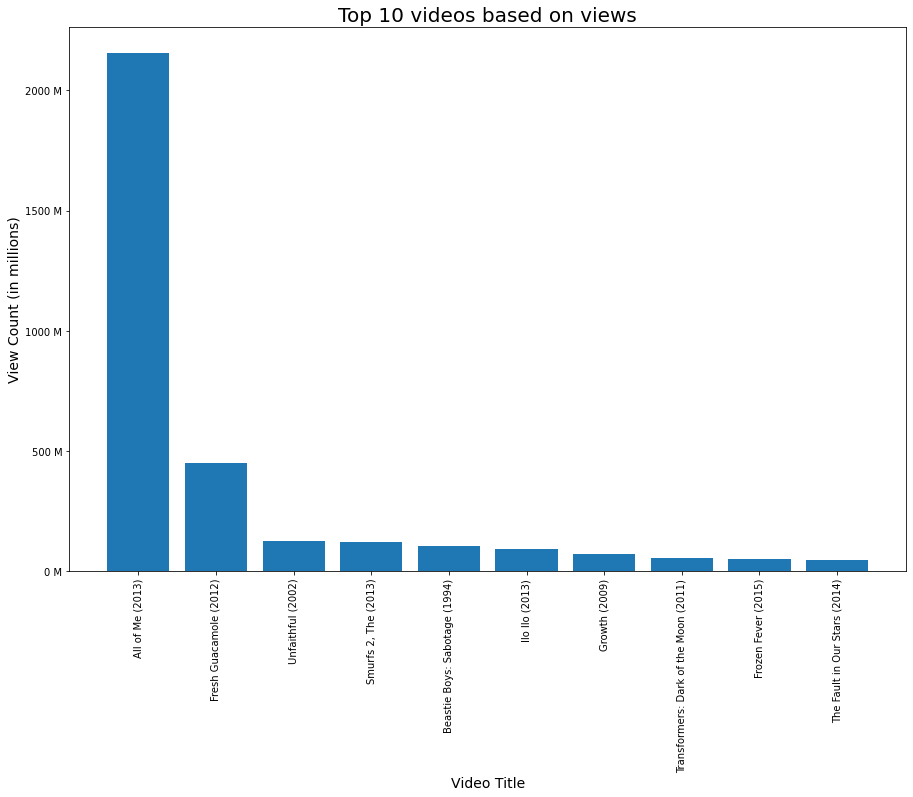

In [35]:
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%.0f M" % (x/1E6)

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(yt_top10_df['title'],yt_top10_df['view_count'])

ax.yaxis.set_major_formatter(million_formatter)

plt.title("Top 10 videos based on views", fontsize=20)
ax.set_xlabel("Video Title", fontsize=14)
ax.set_ylabel("View Count (in millions)", fontsize=14)

plt.xticks(rotation='90')

plt.show()

### 5.2) Bottom-10 videos based on the total views

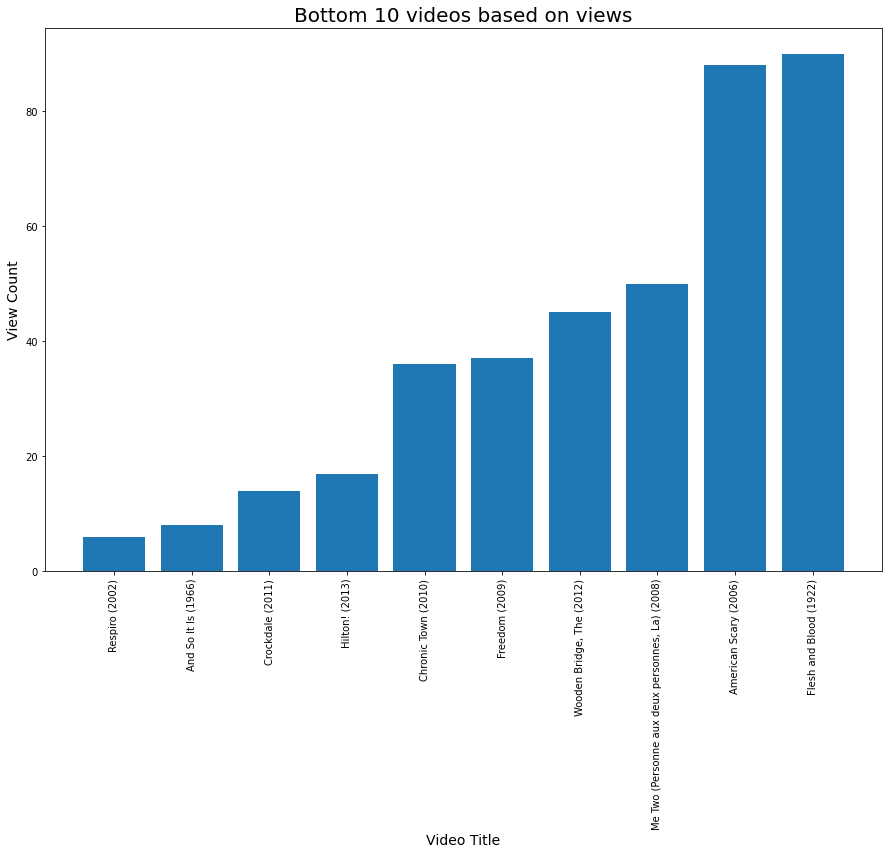

In [36]:
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(yt_bottom10_df['title'], yt_bottom10_df['view_count'])

plt.title("Bottom 10 videos based on views", fontsize=20)
ax.set_xlabel("Video Title", fontsize=14)
ax.set_ylabel("View Count", fontsize=14)

plt.xticks(rotation='90')

plt.show()

### 5.3) Top-10 videos that have the highest positive sentiment scores

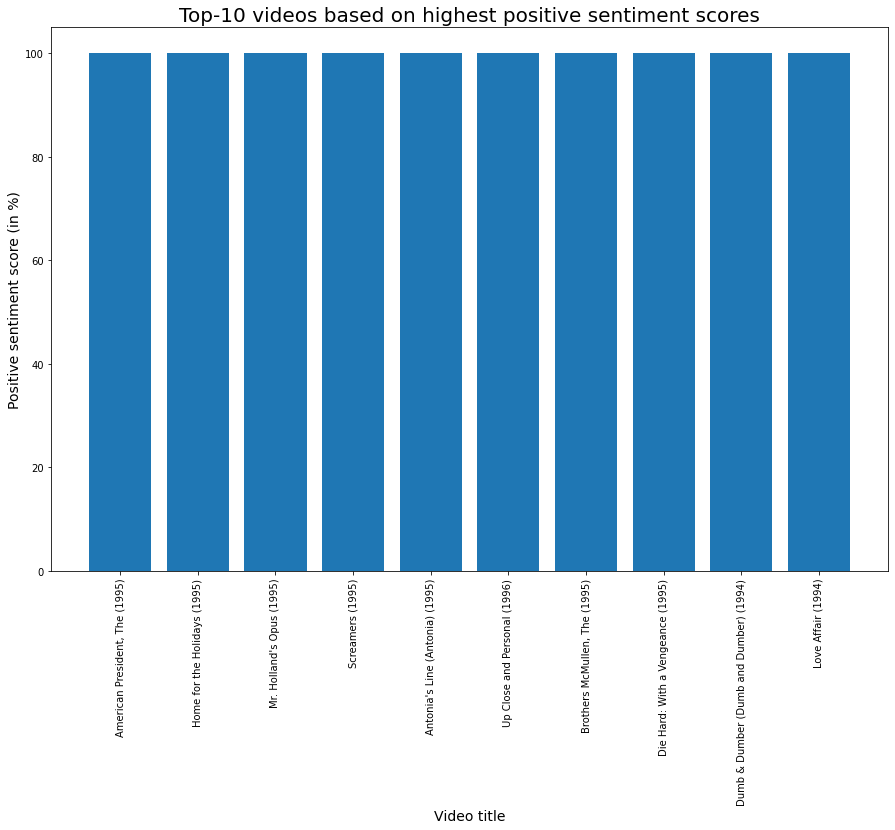

In [59]:
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(comments_positive_top10_df['title'], comments_positive_top10_df['positive_percentage'])

plt.title("Top-10 videos based on highest positive sentiment scores", fontsize=20)
ax.set_xlabel("Video title", fontsize=14)
ax.set_ylabel("Positive sentiment score (in %)", fontsize=14)

plt.xticks(rotation='90')

plt.show()

### 5.4) Bottom-10 videos that have the highest negative sentiment scores

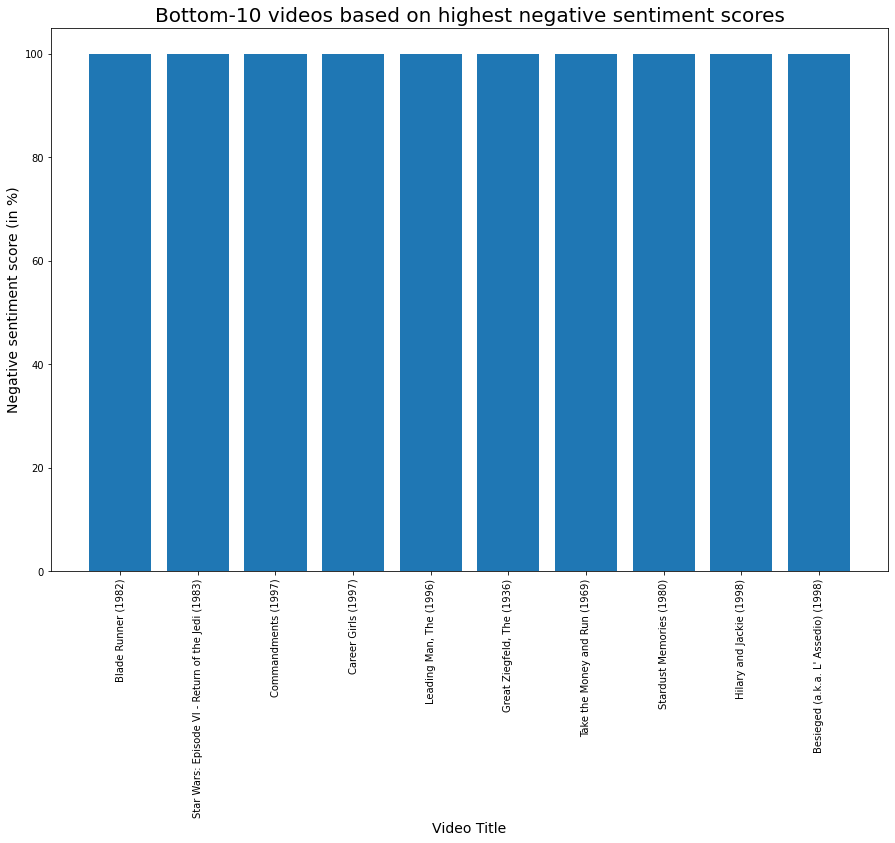

In [60]:
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(comments_negative_top10_df['title'], comments_negative_top10_df['negative_percentage'])

plt.title("Bottom-10 videos based on highest negative sentiment scores", fontsize=20)
ax.set_xlabel("Video Title", fontsize=14)
ax.set_ylabel("Negative sentiment score (in %)", fontsize=14)

plt.xticks(rotation='90')

plt.show()